# *Living Coasts* Information and Training <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls_landcover_class_cyear_2](https://explorer.sandbox.dea.ga.gov.au/ga_ls_landcover_class_cyear_2)


### Plotting changes in woody above ground biomass in a selected area

For selected areas, this notebook allows you to plot changes in woody above ground biomass for multiple years (2010 and annually from 2015-2021) using the global datasets generated by the European Space Agency (ESA) Climate Change Initiative (CCI) Biomass Project (https://climate.esa.int/en/projects/biomass/) and compare the spatial estimates over time with the changes in land cover, as mapped through Geoscience Australia's (GA) Digital Earth Australia (DEA) Land Cover Project.  These land cover maps have been generated for 34 years (1988 to 2020) from environmental descriptors retrieved or classified entirely from Landsat sensor data and according to the Food and Agriculture Organisation (FAO) Land Cover Classification System (Version 2).  If you can interrogate the land cover prior to 2010 (or up to any year after), you might be able to discern some of the reasons for observed AGB levels.  Comparing AGB over the more recent time-series (2010-2020) also informs on how changes in land cover extent and environmental descriptors relating to condition (e.g., canopy cover) have impacted on AGB over time. The spatial resolution of the mapping is 25 m (See DEA Land Cover: https://cmi.ga.gov.au/data-products/dea/607/dea-land-cover-landsat)

## Description 
The notebooks take you through the process of:

1. Observing the land cover changes that have occured over the selected area of interest.
2. Selecting an area of interest and extracting above ground biomass data for 8 years (2010 and annually from 2015 to 2021) and the associated standard deviation of the estimates.
3. Viewing the above ground biomass and change maps based on comparisons of 2010-2020, 2015-2016, 2016-2017, 2017-2018, 2018-2019, 2019-2020 and 2020-2021.

If you are new to DEA Land Cover, it is recommended you look at the introductory [DEA Land Cover notebook](../DEA_datasets/DEA_Land_Cover.ipynb) first. 

***

### Initial imports and setup

In [45]:
# Initial imports and setup
import sys
import os, re
import datacube
import datetime as dt
import geopandas as gpd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib import colormaps
from matplotlib.patches import Patch
from matplotlib import colors as mcolours

import cmocean # for intertidal products
import odc.geo.xr # RML
import pandas as pd
import rioxarray
import warnings
import xarray as xr
import display_tools
import rasterio
from rasterio.crs import CRS

from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.cog import write_cog
from datacube.utils import masking
from datacube.utils.masking import mask_invalid_data
from datacube.utils.geometry import Geometry
from datetime import datetime, timedelta
from dea_tools.plotting import rgb, display_map, plot_wo, xr_animation 
from dea_tools.datahandling import wofs_fuser, load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.dask import create_local_dask_cluster
from display_tools import display_da
from ipyleaflet import DrawControl, FullScreenControl, LayersControl, Map, Rectangle, WidgetControl, basemaps, GeoData # Added rectangle RML
from ipywidgets import Button, Dropdown, FloatText, GridspecLayout, Layout, HBox, VBox, Output, Tab, interact, widgets
from IPython.display import HTML, display
from IPython.core.display import Video
from landcover import lc_colourmap, make_colorbar, plot_land_cover
from odc.algo import xr_reproject
from odc.geo.geom import Geometry
from pyproj import CRS, Proj, transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import LinearRing
from time import time as time
from wdc_datahandling import geopolygon_masking

warnings.filterwarnings("ignore")

dc = datacube.Datacube()
time_range = None

# Ensure openpyxl and tqdm are installed
!pip install openpyxl tqdm
!pip install rasterio

# Manually invoke garbage collection without printing the result
import gc
import contextlib
with contextlib.redirect_stdout(None):
    gc.collect()

# Create local dask cluster to improve data load time
client = create_local_dask_cluster(return_client=True)



Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/34769/status,
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/34769/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39365,Workers: 1
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/34769/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:44857,Total threads: 2
Dashboard: /user/richard.lucas@aber.ac.uk/proxy/36709/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:39845,


###  Selecting your area of interest

In [2]:
from ipyleaflet import Map, DrawControl, Rectangle, WidgetControl, LayersControl, FullScreenControl, GeoJSON, basemaps
from ipywidgets import Button, VBox, Tab, FloatText, Output, Layout, HBox, HTML, Dropdown
from shapely.geometry import Polygon
import gc
import geopandas as gpd
from ipyfilechooser import FileChooser
import json

# Initialize global variables to store the selected polygon
selected_polygon = None
manual_polygon_layer = None
geojson_layer = None

# Define lat_range and lon_range to avoid NameError in Section 5
lat_range = None
lon_range = None

# Create the map
m = Map(center=[0, 0], zoom=2, basemap=basemaps.Esri.WorldImagery, scroll_wheel_zoom=True, layout=Layout(height='600px'))
m.add_control(LayersControl(position='topright'))
m.add_control(FullScreenControl())

# Output widgets to display coordinates
output_draw = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_manual = Output(layout={'border': '1px solid black', 'padding': '5px'})
output_load = Output(layout={'border': '1px solid black', 'padding': '5px'})

### Draw Method ###
# Setup the draw control with both polygon and rectangle options
draw_control = DrawControl(
    rectangle={"shapeOptions": {"color": "#0000FF"}},
    polygon={"shapeOptions": {"color": "#00FF00"}},
    circlemarker={},
    polyline={},
    circle={}
)
m.add_control(draw_control)

# Event handler for drawing shapes
def handle_draw(target, action, geo_json):
    global selected_polygon, lat_range, lon_range
    output_draw.clear_output()
    coords = geo_json['geometry']['coordinates'][0]
    selected_polygon = Polygon(coords)
    lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
    lat_range = (min(lats), max(lats))
    lon_range = (min(lons), max(lons))
    with output_draw:
        output_draw.append_stdout("Coordinates:\n")
        output_draw.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
        for lat, lon in zip(lats, lons):
            output_draw.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")

draw_control.on_draw(handle_draw)

# Button to clear drawings and output
clear_button_draw = Button(description='Clear All')

# Event handler for the clear button
def clear_all_draw(b):
    global selected_polygon, lat_range, lon_range
    draw_control.clear()
    output_draw.clear_output()
    selected_polygon = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_draw.on_click(clear_all_draw)

draw_tab = VBox([clear_button_draw, output_draw])

### Manual Input Method ###
# Create input widgets for manual coordinate entry
latitude = FloatText(description='Latitude:', layout=Layout(width='100%'))
longitude = FloatText(description='Longitude:', layout=Layout(width='100%'))
buffer = FloatText(description='Buffer (deg):', value=0.1, layout=Layout(width='100%'))
update_button = Button(description='Update Map')

# Function to update the map based on manual input values
def update_map_manual(b):
    global manual_polygon_layer, selected_polygon, lat_range, lon_range
    output_manual.clear_output()
    lat = latitude.value
    lon = longitude.value
    buf = buffer.value
    
    if lat is not None and lon is not None and buf is not None:
        bounds = [[lat - buf, lon - buf], [lat + buf, lon + buf]]
        if manual_polygon_layer:
            m.remove_layer(manual_polygon_layer)
        manual_polygon_layer = Rectangle(bounds=bounds, color="blue", fill_opacity=0.2, weight=2)
        m.add_layer(manual_polygon_layer)
        m.fit_bounds(bounds)
        
        selected_polygon = Polygon([(lon - buf, lat - buf), (lon + buf, lat - buf), (lon + buf, lat + buf), (lon - buf, lat + buf), (lon - buf, lat - buf)])
        lat_range = (lat - buf, lat + buf)
        lon_range = (lon - buf, lon + buf)
        
        with output_manual:
            output_manual.append_stdout("Manual Coordinates:\n")
            output_manual.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon - buf:.6f}\n")
            output_manual.append_stdout(f"{lat - buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon + buf:.6f}\n")
            output_manual.append_stdout(f"{lat + buf:.6f}\t\t{lon - buf:.6f}\n")
    else:
        with output_manual:
            output_manual.append_stdout("Please fill in all coordinate values.\n")

# Connect the manual update button
update_button.on_click(update_map_manual)

# Button to clear manual input and output
clear_button_manual = Button(description='Clear All')

# Event handler for the clear button
def clear_all_manual(b):
    global selected_polygon, manual_polygon_layer, lat_range, lon_range
    output_manual.clear_output()
    if manual_polygon_layer:
        m.remove_layer(manual_polygon_layer)
    selected_polygon = None
    manual_polygon_layer = None
    lat_range = None
    lon_range = None
    gc.collect()

clear_button_manual.on_click(clear_all_manual)

manual_tab = VBox([latitude, longitude, buffer, update_button, clear_button_manual, output_manual])

### Load Method ###
# File chooser to load shapefile or GeoJSON
file_chooser = FileChooser(filter_pattern=['*.shp', '*.geojson'])
load_button = Button(description='Load File')

# Function to load and display shapefile or GeoJSON
def load_file(b):
    global geojson_layer, selected_polygon, lat_range, lon_range
    output_load.clear_output()
    
    file_path = file_chooser.selected
    
    if file_path:
        if file_path.endswith('.shp'):
            gdf = gpd.read_file(file_path)
            geo_json_data = json.loads(gdf.to_json())
        elif file_path.endswith('.geojson'):
            with open(file_path) as f:
                geo_json_data = json.load(f)
        
        if geojson_layer:
            m.remove_layer(geojson_layer)
        
        geojson_layer = GeoJSON(data=geo_json_data, style={'color': 'green', 'fillOpacity': 0.5})
        m.add_layer(geojson_layer)
        
        coords = geo_json_data['features'][0]['geometry']['coordinates'][0]
        selected_polygon = Polygon(coords)
        lats, lons = zip(*[(coord[1], coord[0]) for coord in coords])
        lat_range = (min(lats), max(lats))
        lon_range = (min(lons), max(lons))
        
        m.fit_bounds([[min(lats), min(lons)], [max(lats), max(lons)]])
        
        with output_load:
            output_load.append_stdout(f"Loaded {file_path}\n")
            output_load.append_stdout("Coordinates:\n")
            output_load.append_stdout(f"{'Latitude':<20}{'Longitude'}\n")
            for lat, lon in zip(lats, lons):
                output_load.append_stdout(f"{lat:.6f}\t\t{lon:.6f}\n")
    else:
        with output_load:
            output_load.append_stdout("Please select a file.\n")

load_button.on_click(load_file)

# Load method tab layout
load_tab = VBox([file_chooser, load_button, output_load])

### Main Method Selection Tab ###
# Add all tabs to the main method selection tab
method_tab = Tab()
method_tab.children = [draw_tab, manual_tab, load_tab]
method_tab.set_title(0, 'Draw Method')
method_tab.set_title(1, 'Manual Input Method')
method_tab.set_title(2, 'Load Method')

# Add the method selection tab control to the map
method_control = WidgetControl(widget=method_tab, position='topright')
m.add_control(method_control)

# Create a subtle tab for collapsing/expanding the menu using Button
collapse_button = Button(description=">", layout=Layout(width='30px', height='30px'))

# Event handler for the collapse/expand button
def toggle_collapse(b):
    if method_control in m.controls:
        m.remove_control(method_control)
        collapse_button.description = "<"
    else:
        m.add_control(method_control)
        collapse_button.description = ">"

collapse_button.on_click(toggle_collapse)

# Add the collapse button to the map
collapse_control = WidgetControl(widget=collapse_button, position='topright')
m.add_control(collapse_control)

# Display the map
display(m)

print("Draw, Manual Input, and Load methods setup with menu toggle completed.")

# Manually invoke garbage collection
gc.collect()


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

Draw, Manual Input, and Load methods setup with menu toggle completed.


0

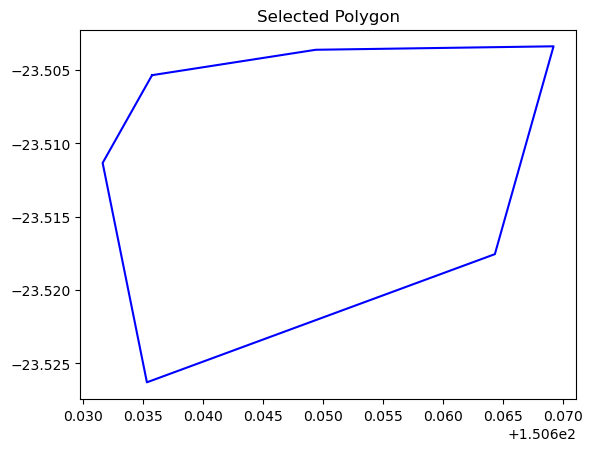

In [3]:
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry.polygon import LinearRing

# Function to convert latitude and longitude to UTM coordinates
def latlon_to_utm(lat, lon):
    utm_proj = Proj(proj="utm", zone=55, datum="WGS84")  # Change zone as needed - *** WAS 33 as DEFAULT
    utm_x, utm_y = utm_proj(lon, lat)
    return utm_x, utm_y

# Function to display the selected coordinates, UTM coordinates, and visualize the polygon
def display_selected_coordinates(selected_polygon):
    if selected_polygon is not None:
        coords = selected_polygon.exterior.coords
        utm_coords = [latlon_to_utm(lat, lon) for lon, lat in coords]

#        print("The drawn shape was used for selection.")
#        print("The geopolygon of interest is the following one; ")
#        print(selected_polygon)

#        print("\nSelected Polygon Coordinates:")
#        for lon, lat in coords:
#            print(f"Latitude: {lat}, Longitude: {lon}")

#        print("\nUTM Coordinates:")
#        for utm_x, utm_y in utm_coords:
#            print(f"UTM X: {utm_x}, UTM Y: {utm_y}")

        # Visualize the selected polygon
        ring = LinearRing(coords)
        fig, ax = plt.subplots()
        ax.plot(*ring.xy, color="blue")
        ax.set_title("Selected Polygon")
        plt.show()
    else:
        print("No polygon selected")

# Call the function to display the coordinates and visualize the polygon
# Assuming you have the selected polygon stored in a variable named 'selected_polygon'
display_selected_coordinates(selected_polygon)


### Reviewing your area of interest

In [4]:
from datetime import datetime
from IPython.display import display
from ipywidgets import widgets

# Input widgets for specifying the year range
start_date_input = widgets.DatePicker(
    description="Start Date", value=datetime(2010, 1, 1)  # Default value (example)
)

end_date_input = widgets.DatePicker(
    description="End Date", value=datetime(2020, 12, 31)  # Default value (example)
)

# Display date pickers
display(start_date_input, end_date_input)

# Update the global variables with the selected time range
def update_time_range(change):
    global time_range
    start_date = start_date_input.value
    end_date = end_date_input.value
    time_range = (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'))
    print(f"Selected time range: {time_range}")

# Attach the update function to the date pickers
start_date_input.observe(update_time_range, names='value')
end_date_input.observe(update_time_range, names='value')

# Initial call to set the time range
update_time_range(None)


DatePicker(value=datetime.datetime(2010, 1, 1, 0, 0), description='Start Date', step=1)

DatePicker(value=datetime.datetime(2020, 12, 31, 0, 0), description='End Date', step=1)

Selected time range: ('2010-01-01', '2020-12-31')


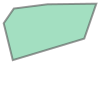

In [5]:
selected_polygon

In [6]:
gdf = gpd.GeoDataFrame({'geometry': [selected_polygon]}, crs="EPSG:4326")

In [7]:
gdf.head()

,geometry
0,"POLYGON ((150.63572 -23.50535, 150.64937 -23.5..."


In [8]:
gdf.explore()

In [9]:
# Dictionary to save results
results = {}

In [10]:
# Section 5: Load Data from Datacube

# Step 1: Check if required variables are defined
if lat_range is None or lon_range is None or start_date_input.value is None or end_date_input.value is None:
    raise ValueError("Latitude, Longitude, or Time range is not defined")

print("Lat Range:", lat_range)
print("Lon Range:", lon_range)
print("Start Date:", start_date_input.value)
print("End Date:", end_date_input.value)

# Step 2: Construct the query
query = {
    "y": lat_range,
    "x": lon_range,
    "time": (start_date_input.value, end_date_input.value),
}

print("Query Parameters:", query)

# Step 3: Load DEA Land Cover data from the datacube
try:
    lc = dc.load(
        product="ga_ls_landcover_class_cyear_2",
        output_crs="EPSG:3577",
        measurements=[
            "level3",
            "lifeform",
            "vegetation_cover",
            "water_seasonality",
            "water_state",
            "intertidal",
            "water_persistence",
            "bare_gradation",
            "full_classification",
        ],
        resolution=(-25, 25),
        **query
    )
    print("Data loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading data from the datacube: {e}")

# Step 4: Check if the dataset is loaded correctly
if lc is None or lc.geobox is None:
    raise ValueError("Failed to load the dataset. Please check the query parameters and ensure data is available for the specified region and time range.")   
    
# Step 5: Print geobox information
geobox = lc.geobox

geobox_info = f"""
Geobox Information:
-------------------
CRS: {geobox.crs}
Dimensions: {geobox.dimensions}
Resolution: {geobox.resolution}
Shape: {geobox.shape}
Extent: {geobox.extent}
"""

print(geobox_info)

# Step 6: Check loaded data dimensions and variables
print("Loaded data dimensions:", lc.dims)
print("Loaded data variables:", lc.data_vars)


Lat Range: (-23.526287, -23.503385)
Lon Range: (150.631603, 150.669197)
Start Date: 2010-01-01 00:00:00
End Date: 2020-12-31 00:00:00
Query Parameters: {'y': (-23.526287, -23.503385), 'x': (150.631603, 150.669197), 'time': (datetime.datetime(2010, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 0, 0))}
Data loaded successfully.

Geobox Information:
-------------------
CRS: PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
from pyproj import CRS
from rasterio.warp import Resampling
import datetime
import os

# Define the folder paths
base_paths = {
    "S20E150": "uploads/AGB/S20E150_Qld_SEast/",
    "S10E140": "uploads/AGB/S10E140_Qld_North/",
    "S30E110": "uploads/AGB/S30E110_WA_SWest/",
    "S30E120": "uploads/AGB/S30E120_WA_SEast/"
}

# Define the file naming formats
file_formats = {
    "AGB": "{folder_name}_{year}_AGBcz.tif",
    "SD": "{folder_name}_{year}_SDcz.tif"
}

# Function to determine folder name based on latitude and longitude ranges
def get_folder_name_from_lat_lon(lat_range, lon_range):
    folder_mapping = {
        "S20E150": (-30, -20, 150, 160),
        "S10E140": (-20, -10, 140, 150),
        "S30E110": (-40, -30, 110, 120),
        "S30E120": (-40, -30, 120, 130)
    }
    for folder_name, (lat_min, lat_max, lon_min, lon_max) in folder_mapping.items():
        if lat_range[0] >= lat_min and lat_range[1] <= lat_max and lon_range[0] >= lon_min and lon_range[1] <= lon_max:
            return folder_name
    raise ValueError("No data folder found for the provided latitude and longitude ranges.")

# Function to handle reading and reprojection
def rio_slurp_xarray(file_path, geobox=None, resampling=Resampling.nearest):
    try:
        da = rioxarray.open_rasterio(file_path, chunks="auto")
        if da.rio.crs is None:
            raise ValueError(f"Source data at {file_path} does not have CRS information.")
        if geobox is not None:
            da = da.rio.reproject(
                dst_crs=geobox.crs,
                shape=geobox.shape,
                resampling=resampling,
                transform=geobox.affine,
                nodata=da.rio.nodata
            )
        return da
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return xr.DataArray()

# Function to mask invalid data
def mask_invalid_data(data):
    return data.where(~np.isnan(data))

# Function to load and process data for the given folder and years
def process_data_for_folder(folder_name, years, geobox):
    base_path = base_paths[folder_name]
    file_format = file_formats["AGB"]
    sd_file_format = file_formats["SD"]

    AGB_prj_all = {}
    SD_prj_all = {}
    
    for year in years:
        AGB_file = os.path.join(base_path, file_format.format(folder_name=folder_name, year=year))
        SD_file = os.path.join(base_path, sd_file_format.format(folder_name=folder_name, year=year))

        if os.path.exists(AGB_file):
            AGB_prj_all[year] = mask_invalid_data(rio_slurp_xarray(AGB_file, geobox=geobox, resampling=Resampling.nearest))
            AGB_prj_all[year] = AGB_prj_all[year].where(AGB_prj_all[year] != 0)
        else:
            print(f"Warning: AGB file for {folder_name}, year {year} not found.")
            AGB_prj_all[year] = xr.DataArray(data=np.zeros(geobox.shape), dims=geobox.dims, coords=geobox.coords)

        if os.path.exists(SD_file):
            SD_prj_all[year] = mask_invalid_data(rio_slurp_xarray(SD_file, geobox=geobox, resampling=Resampling.nearest))
        else:
            print(f"Warning: SD file for {folder_name}, year {year} not found. Setting SD to zero.")
            SD_prj_all[year] = xr.DataArray(data=np.zeros(AGB_prj_all[year].shape), dims=AGB_prj_all[year].dims, coords=AGB_prj_all[year].coords)

    AGB = xr.Dataset({f"AGB{year}": AGB_prj_all[year] for year in years})
    SD = xr.Dataset({f"SD{year}": SD_prj_all[year] for year in years})

    # Calculate differences
    diff_biomass = xr.Dataset({
        f"d{years[i]}_{years[i+1]}": (AGB[f"AGB{years[i+1]}"].fillna(0) - AGB[f"AGB{years[i]}"].fillna(0)).where(
            (AGB[f"AGB{years[i+1]}"].fillna(0) - AGB[f"AGB{years[i]}"].fillna(0)) != 0
        )
        for i in range(len(years) - 1)
    })

    diff_biomass_all = {folder_name: diff_biomass}

    min_biomass = xr.Dataset({
        f"AGB{year}_Min": AGB[f"AGB{year}"] - SD[f"SD{year}"]
        for year in years
    })
    max_biomass = xr.Dataset({
        f"AGB{year}_Max": AGB[f"AGB{year}"] + SD[f"SD{year}"]
        for year in years
    })

    min_biomass_all = {folder_name: min_biomass}
    max_biomass_all = {folder_name: max_biomass}

    agb_sc_dec = xr.Dataset({
        f"cond_dec_{years[i]}_{years[i+1]}": (min_biomass[f"AGB{years[i]}_Min"].fillna(0) > max_biomass[f"AGB{years[i+1]}_Max"].fillna(0))
        for i in range(len(years) - 1)
    })

    agb_sc_inc = xr.Dataset({
        f"cond_inc_{years[i]}_{years[i+1]}": (max_biomass[f"AGB{years[i]}_Max"].fillna(0) < min_biomass[f"AGB{years[i+1]}_Min"].fillna(0))
        for i in range(len(years) - 1)
    })

    agb_sc = xr.merge([agb_sc_dec, agb_sc_inc])
    agb_sc_all = {folder_name: agb_sc}

    return AGB_prj_all, SD_prj_all, diff_biomass_all, min_biomass_all, max_biomass_all, agb_sc_all

# Query Parameters
years = [2010, 2015, 2016, 2017, 2018, 2019, 2020, 2021]  # Specify the years


# Determine the folder name based on latitude and longitude ranges
folder_name = get_folder_name_from_lat_lon(lat_range, lon_range)
print(f"Selected folder name: {folder_name}")

# Process data for the selected folder using the provided geobox
AGB_prj_all, SD_prj_all, diff_biomass_all, min_biomass_all, max_biomass_all, agb_sc_all = process_data_for_folder(folder_name, years, geobox)

# Combine the AGB_prj_all into a single xarray.Dataset called AGB
AGB = xr.Dataset({f"AGB{year}": AGB_prj_all[year] for year in years})

# Now, AGB contains the AGB data for each year as separate variables
# Combine the diff_biomass_all into a single xarray.Dataset called diff_biomass
diff_biomass = diff_biomass_all[folder_name]
agb_sc = agb_sc_all[folder_name]

Selected folder name: S20E150


### Select the time-period (**for DEA land cover only**)

#### Access ESA CCI Biomass datasets (2010 and annually from 2015-2021)

In [26]:
bounds = np.array([10, 10, 40, 40])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=100)
print(norm([10,40]))

[49 100]


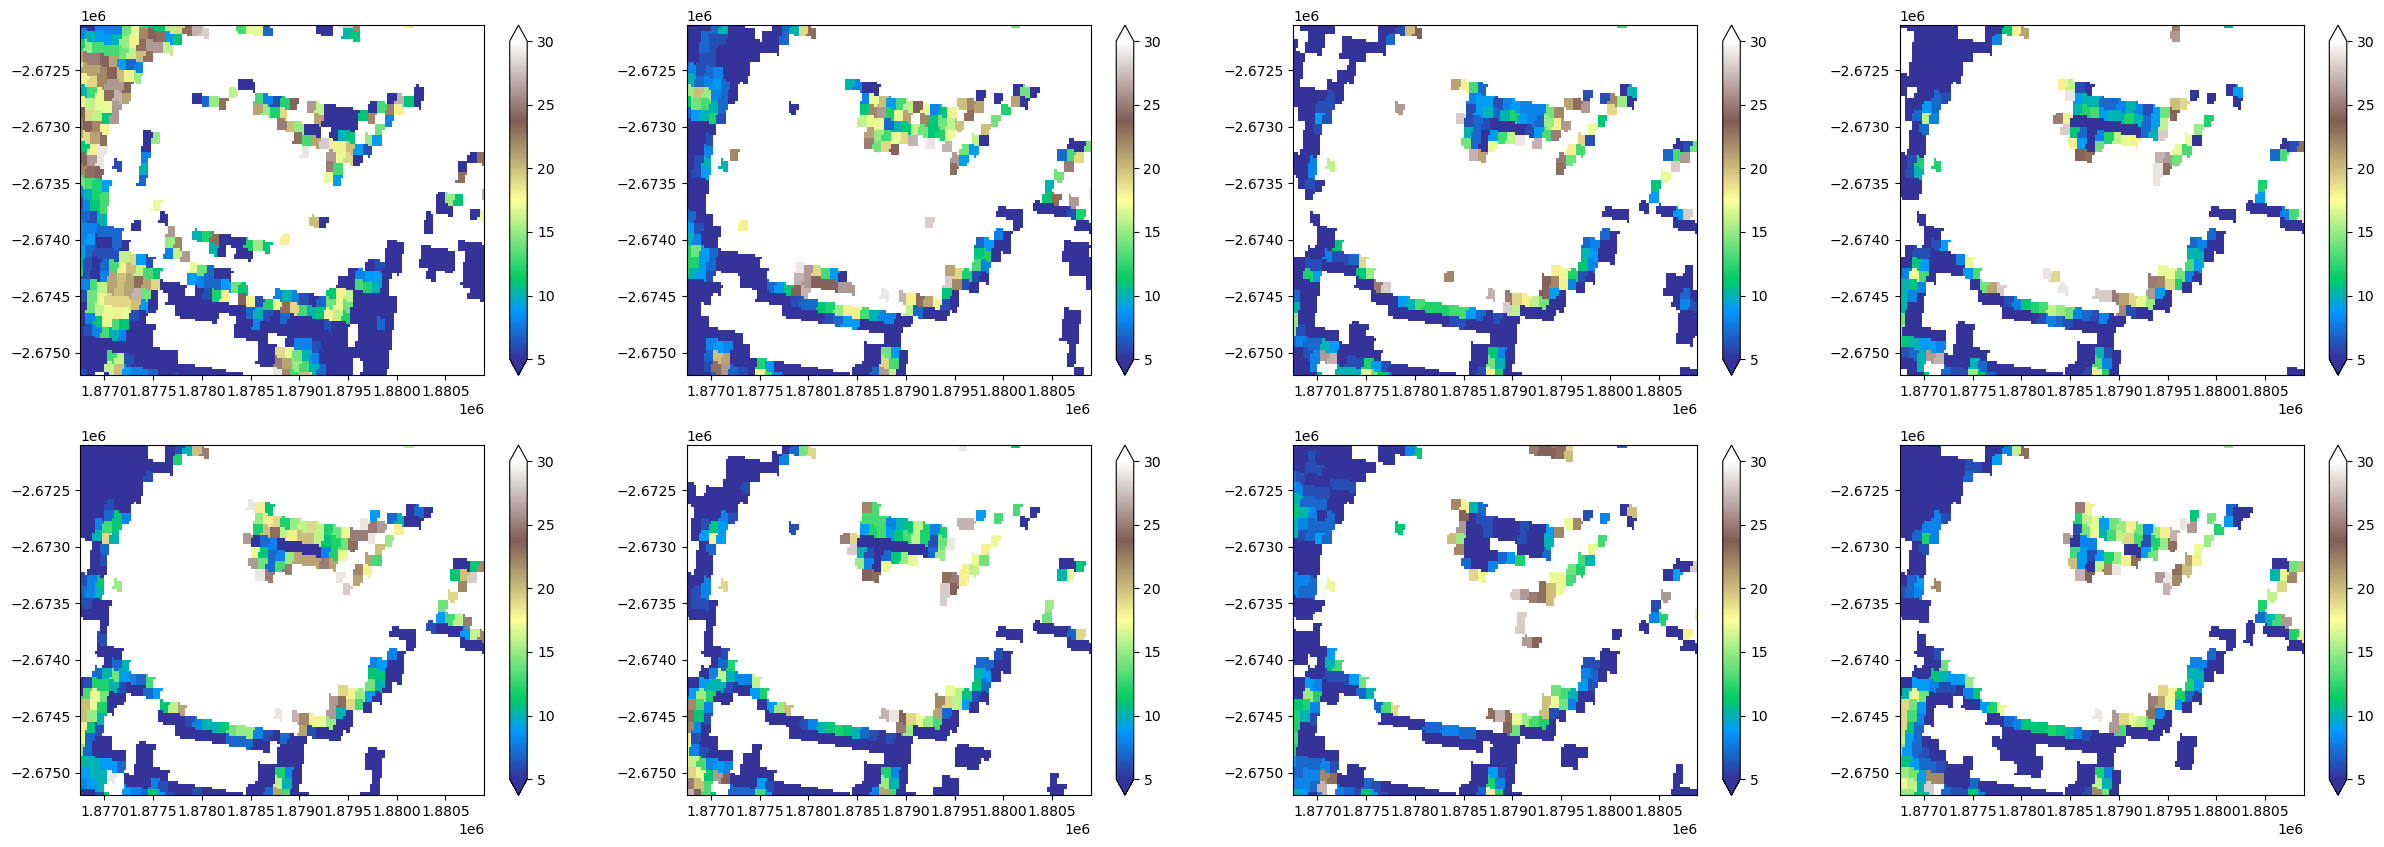

In [27]:
AGB_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
AGB.AGB2010.plot(ax=axs[0,0], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2015.plot(ax=axs[0,1], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2016.plot(ax=axs[0,2], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2017.plot(ax=axs[0,3], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2018.plot(ax=axs[1,0], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2019.plot(ax=axs[1,1], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2020.plot(ax=axs[1,2], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)
AGB.AGB2021.plot(ax=axs[1,3], cmap='terrain', vmin = 5, vmax = 30, add_labels=False)

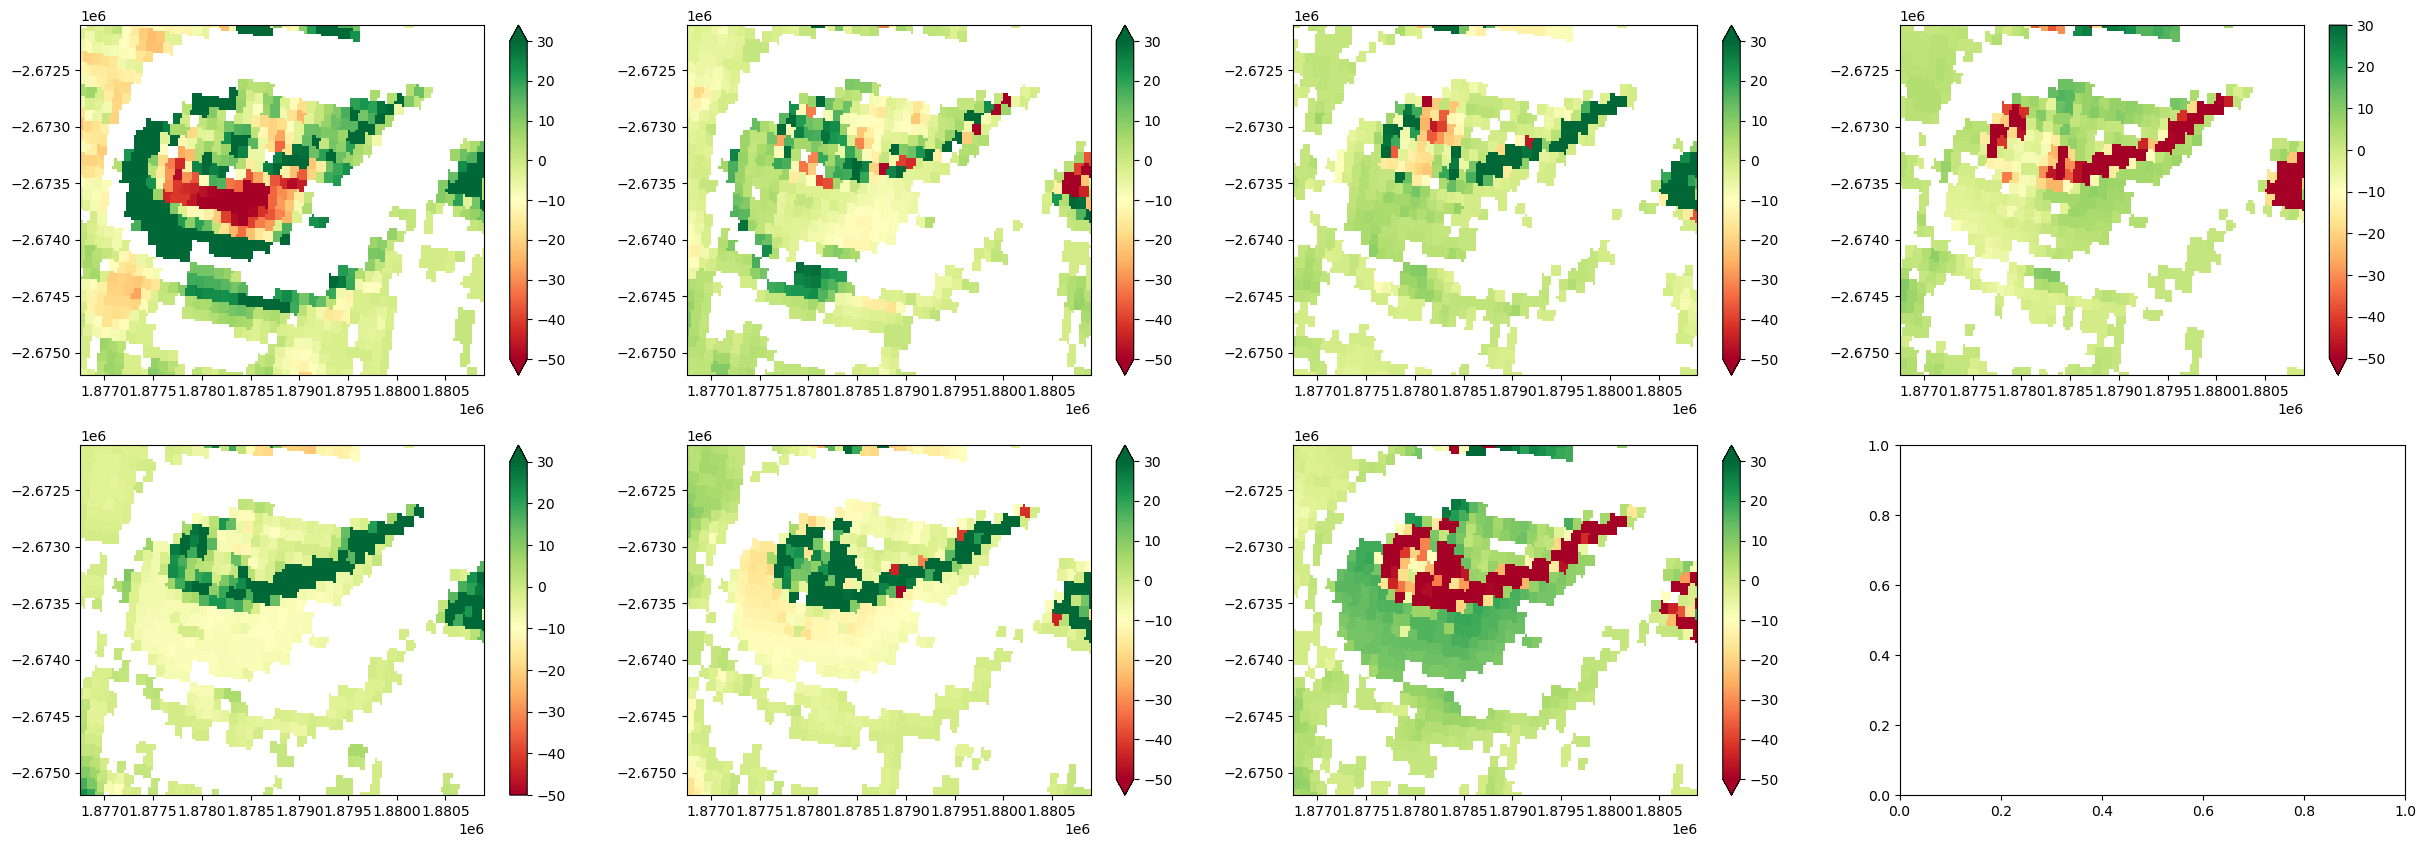

In [29]:
AGB_diff_fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize=(30, 10))
diff_biomass.d2010_2015.plot(ax=axs[0,0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2015_2016.plot(ax=axs[0,1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2016_2017.plot(ax=axs[0,2], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2017_2018.plot(ax=axs[0,3], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2018_2019.plot(ax=axs[1,0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2019_2020.plot(ax=axs[1,1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2020_2021.plot(ax=axs[1,2], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)

### View datasets of biomass and biomass change for selected years

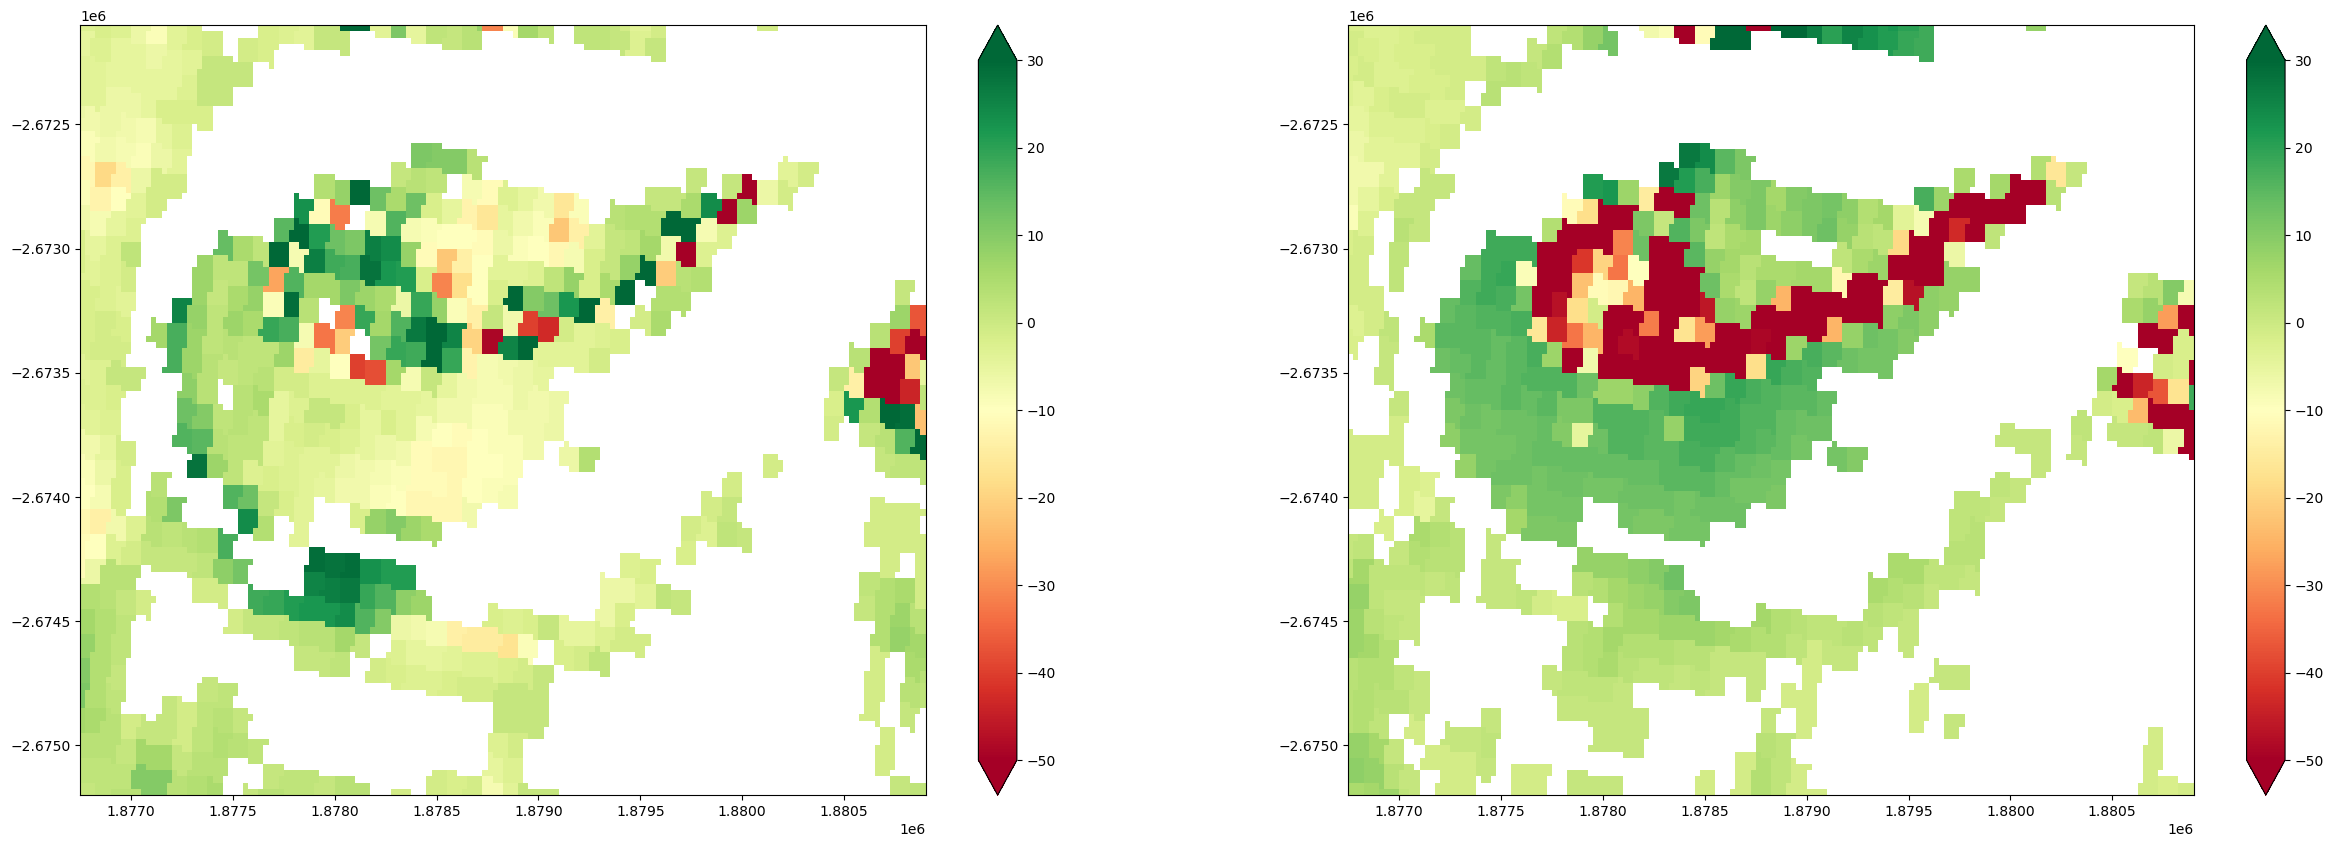

In [33]:
AGB_diff_fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(30, 10))
diff_biomass.d2015_2016.plot(ax=axs[0], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)
diff_biomass.d2020_2021.plot(ax=axs[1], cmap='RdYlGn', vmin = -50, vmax = 30, add_labels=False)


### Simple differencing of AGB stocks

AGB change as the simple difference in AGB stocks internally between years. The standard deviation of the simple differencing method is provided in the ESA product for the 2017-2018, 2018-2019 and 2019-2020 differences. It reflects the precision of AGB change and is calculated using the square root of the sum of the variances. A quality flag layer is also provided to interpret the reliability of the difference detected by pixel. The quality was determined depending on whether the AGB histograms associated with the pixel at the two epochs were overlapping (in-significant difference) or disjoint (significant difference). The significance of the AGB difference is extracted from the quality flag layer. The simple differencing method is it can maximise accuracy for measuring the amount and direction of change.

#### Create a new layer where the change is significant (e.g., cond_decrease = AGB2018_Min gt AGB2019_Max)
Identify where the maximum value of the earlier year (e.g., 2018) is less than the minimum of the later year (e.g., 2019) (INCREASE) and where the minimum value of earlier year is greater than the maximum of later (gain) (i.e., t1max.lt(t2min).or(t1min.gt(t2max))

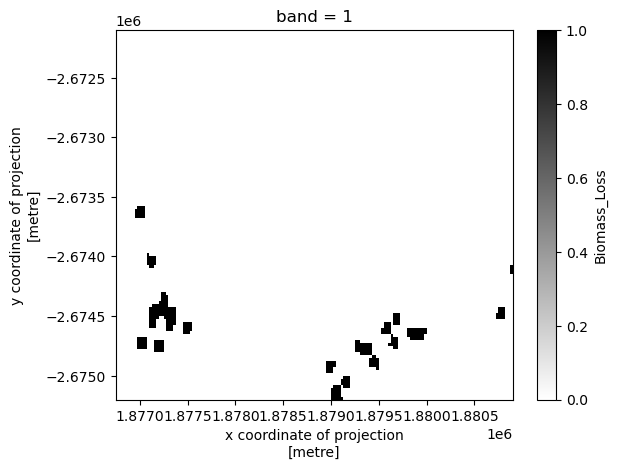

In [35]:
folder_name = get_folder_name_from_lat_lon(lat_range, lon_range)

diff_biomass = diff_biomass_all[folder_name]

agb_sc = agb_sc_all[folder_name]

diff_biomass_var = 'd2010_2015'  
cond_dec_var = 'cond_dec_2010_2015'  

Biomass_Loss = np.where(
    (diff_biomass[diff_biomass_var] < 0) & (agb_sc[cond_dec_var] == 1),
    1,
    0
)

Biomass_Lossxa = xr.DataArray(
    data=Biomass_Loss,
    coords={
        'band': diff_biomass[diff_biomass_var].coords['band'],
        'y': diff_biomass[diff_biomass_var].coords['y'],
        'x': diff_biomass[diff_biomass_var].coords['x']
    },
    dims=['band', 'y', 'x'],
    name="Biomass_Loss"
)

Biomass_Lossxa = Biomass_Lossxa
Biomass_Lossxa.plot(cmap='binary')

In [47]:
# Load the RGB data using the selected coordinates and time range
ds = dc.load(product="ga_ls8c_nbart_gm_cyear_3",
             x=lon_range,
             y=lat_range,
             time="2020",
             measurements=["red", "green", "blue"],
             output_crs="EPSG:4326",  # Assuming lat/lon coordinates
             resolution=(-0.00025, 0.00025))  # Adjust resolution as needed


In [48]:
from matplotlib.colors import Normalize
from skimage import exposure
 
# Function to create RGB image

def create_rgb_image_adjusted(ds, bands=["red", "green", "blue"], index=0, blend_factor=0.5):
    # Extract the bands
    red = ds[bands[0]].isel(time=index).values
    green = ds[bands[1]].isel(time=index).values
    blue = ds[bands[2]].isel(time=index).values
 
    # Apply histogram equalization
    red_eq = exposure.equalize_hist(red)
    green_eq = exposure.equalize_hist(green)
    blue_eq = exposure.equalize_hist(blue)
 
    # Blend the original and equalized images
    red_blended = blend_factor * red_eq + (1 - blend_factor) * Normalize(vmin=red.min(), vmax=red.max())(red)
    green_blended = blend_factor * green_eq + (1 - blend_factor) * Normalize(vmin=green.min(), vmax=green.max())(green)
    blue_blended = blend_factor * blue_eq + (1 - blend_factor) * Normalize(vmin=blue.min(), vmax=blue.max())(blue)
 
    # Stack bands into an RGB array
    rgb_array = np.stack([red_blended, green_blended, blue_blended], axis=-1) 
    # Convert to 8-bit image
    return (rgb_array * 255).astype(np.uint8)
 
# Create the RGB image with adjusted histogram equalization
rgb_image_adjusted = create_rgb_image_adjusted(ds, blend_factor=0.3)  # Adjust blend_factor as needed 

In [49]:
# Reproject the mask dataset to match the RGB dataset
mask_resampled = Biomass_Lossxa.rio.reproject_match(ds)
mask_dataarray = mask_resampled.to_array().squeeze()  # Flatten into a 2D array if necessary

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10)) 
import matplotlib.pyplot as plt
 
# Prepare the plot
#fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
 
extent = [ds.longitude.min().item(), ds.longitude.max().item(), ds.latitude.min().item(), ds.latitude.max().item()]
 
# Determine the number of layers in `mask_dataarray`
num_layers = mask_dataarray.sizes['variable'] if 'variable' in mask_dataarray.dims else 1
 
# Plot each layer or the available layers
for i, ax in enumerate(axs.flatten()):
    ax.imshow(rgb_image_adjusted, extent=extent)
 
    if i < num_layers:
        # Select the i-th layer from `mask_dataarray` if it exists
        if num_layers > 1:
            mask_layer = mask_dataarray.isel(variable=i)
        else:
            mask_layer = mask_dataarray
        mask_layer = mask_layer.where(mask_layer != 0)  # Set non-masked areas to NaN to make them transparent
 
        ax.imshow(mask_layer, cmap='spring', alpha=0.5, extent=extent)
        ax.set_title(f'Mask Overlay {i+1}')
    else:
        ax.set_title('No More Masks')
        ax.axis('off')
        
plt.show()

MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: Biomass_Loss

### View maps of DEA land cover for the same area

In [1]:
#  Checkbox widgets for selecting datasets
level3_checkbox = widgets.Checkbox(description='Level 3', value=False)
lifeform_checkbox = widgets.Checkbox(description='Lifeform', value=False)
vegetation_cover_checkbox = widgets.Checkbox(description='Vegetation Cover', value=False)
water_state_checkbox = widgets.Checkbox(description='Water State', value=False)
water_persistence_checkbox = widgets.Checkbox(description='Water Persistence', value=False)
full_classification_checkbox = widgets.Checkbox(description='Full Classification', value=False)
item_checkbox = widgets.Checkbox(description='Intertidal Elevation', value=False)

output = widgets.Output()

def plot_selected_datasets():
    with output:
        output.clear_output()
        selected_datasets = []
        if level3_checkbox.value:
            selected_datasets.append('level3')
        if lifeform_checkbox.value:
            selected_datasets.append('lifeform')
        if vegetation_cover_checkbox.value:
            selected_datasets.append('vegetation_cover')
        if water_state_checkbox.value:
            selected_datasets.append('water_state')
        if water_persistence_checkbox.value:
            selected_datasets.append('water_persistence')            
        if full_classification_checkbox.value:
            selected_datasets.append('full_classification')
        if item_checkbox.value:
            selected_datasets.append('item')

        for dataset in selected_datasets:
            plt.figure()
            if dataset == 'level3':
                plot_land_cover(lc.level3)
            elif dataset == 'lifeform':
                plot_land_cover(lc.lifeform)
            elif dataset == 'vegetation_cover':
                plot_land_cover(lc.vegetation_cover)
            elif dataset == 'water_state':
                plot_land_cover(lc.water_state)
            elif dataset == 'water_persistence':
                plot_land_cover(lc.water_persistence)
            elif dataset == 'full_classification':
                plot_land_cover(lc.full_classification)
            elif dataset == 'item':
                plot_land_cover(item.elevation[0])
            plt.show()

plot_datasets_button = widgets.Button(description='Plot Selected Data')
plot_datasets_button.on_click(lambda b: plot_selected_datasets())

checkboxes_box = widgets.HBox([
    level3_checkbox, 
    lifeform_checkbox, 
    vegetation_cover_checkbox, 
    water_state_checkbox, 
    water_persistence_checkbox, 
    full_classification_checkbox,
    item_checkbox
])
display(checkboxes_box)
display(plot_datasets_button)
display(output)

NameError: name 'widgets' is not defined

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)

**Tags**: :index:`sandbox compatible`, :index:`landsat 5`, :index:`landsat 7`, :index:`landsat 8`, 
:index:`DEA Land Cover`, :index:`time series`, :index: `LCCS`, :index:`colour maps`, :index:`data visualisation`